# Oral exam 

## Assignment

For the oral exam, students are asked to present **3 different Machine Learning Techniques**. They can be chosen from the problems given in *Yaser S. Abu-Mostafa, Malik Magdon-Ismael and Hsuan-Tien Lin "Learning from Data"*.

Example problems are: 

   * Problems 1.4 and 1.5 (pp. 34-35). These problems study the Perceptron Learning Algorithm (PLA) on artifical data sets. The first one asks to investigate the PLA on data sets of different size and dimension. And the second one asks to study a variant that includes an extra parameter, the learning rate $\eta$.
   * Problem 3.3 (p. 109) studies the PLA and its pocket variant on a orginal non-linear separable dataset and a third order polynomial feature transformation of that set.
   * Problem 4.4 (p. 155) sets up an experimental framework to study overfitting.
   * Problem 4.24 (p. 163) investigates linear regression with weight decay regularization.
   * Also in the Problems Section of the e-Chapters on Neural Networks, Support Vector Machines, and Similarity-Based Methods you will find assignments that you can do. 
   
**Alternatively**, you can also present a project of your own choice but you should discuss this with me beforehand. Also, that project should involve the same amount of work needed to do the assginment described above. 


## Requirements

  1. Jupyter notebook using the Python ecosystem, i.e. the libraries *numpy* and *scipy* to implement the algorithms and *matplotlib* (or *seaborn*) to display the results of the experiments. 
  
  2. The notebook should be self-contained, it contains text explaining the machine learning algorithm and the hypotheses investigated in the assignment. Relevant theory is also mentioned.
  
  3. Results are visualized.
  
## Example

Cf. below

# Introduction

In this notebook we study the **Hoeffding inequality**.

   * We do the coin experiment described in Exercise 1.10 of "Learning from Data" (p. 23).
Its purpose is to illustrate the difference between *verifying* a hypothesis and *learning* the best hypothesis.

   * The Hoeffding inequality only holds when some conditions are met. We check the inequaltiy on a number of distributions. For some of them these conditions hold, for others not.

   * We compare the Hoeffding and Chebyshev inequalities. The second one is valid for every distribution with finite variance but gives a looser bound than Hoeffding when applicable.

But first of all we implement some functions to classify and visualize the probability distributions of the module *scipy.stats*.

# Imports

Import the module *numpy*, from *scipy* the *stats* module and from *math* the function *ceil* since it returns an integer as opposed to *np.ceil* that returns a floating point number.

In [1]:
import numpy as np
import scipy.stats as ss
from math import ceil
%precision 10

'%.10f'

Import the module *numba*. It provides an easy way to vectorize Python functions. The resulting vectorized function can then 
be applied to a whole range of values at once, cf. the cells below with the @vectorize decorator.

In [2]:
from numba import vectorize, boolean, float64, int64

Import whatever is needed to generate plots.

In [3]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline

# Probability distributions

We use some probability distributions from the module *scipy.stats*. These can be classified as 

   * *continuous* or *discrete*, e.g. Gaussian and Beta distributions are continuous while the binomial and Poisson distributions are discrete 
   * whose values are *bounded* or *not*, e.g. binomial and Beta distributions are bouned while and the Gaussian and Poisson distributions are unbouded.
    
The function *plot_rv* visualizes these distributions.

## Some distributions with *bounded range*

In [4]:
B_30 = ss.bernoulli(p=0.3)
B_50 = ss.bernoulli(p=0.5)
U = ss.uniform()
Beta_5_5 = ss.beta(5, 5)

## Some distributions with *unbounded range*

In [5]:
G = ss.norm(loc=0, scale=1)
P_1 = ss.poisson(mu=1)
P_5 = ss.poisson(mu=5)
Chi2_5 = ss.chi2(df=5,loc=0, scale=1)

In [6]:
RVs = [B_30, B_50, U, Beta_5_5, G, P_1, P_5, Chi2_5]

## Classify distributions

In [7]:
def continuous_p(rv):
    rv_name = rv.dist.name
    return isinstance(getattr(ss, rv_name), ss.rv_continuous)
 
def discrete_p(rv): 
    rv_name = rv.dist.name
    return isinstance(getattr(ss, rv_name), ss.rv_discrete) 

In [8]:
def bounded_by_unit_interval_p(rv):
    return rv.a == 0.0 and rv.b == 1.0

def bounded_p(rv):
    return np.NINF < rv.a and rv.b < np.PINF

## Visualize distributions

In [9]:
PPF_BOUNDS = {(False, False):{'ppf_min':0.0, 'ppf_max':1.0},
              (False, True):{'ppf_min':0.0, 'ppf_max':0.99},
              (True, False):{'ppf_min':0.01, 'ppf_max':1.0},
              (True, True):{'ppf_min':0.01, 'ppf_max':0.99}}

def get_ppf_bounds(rv):
    global PPF_BOUNDS
    bounds = PPF_BOUNDS[(rv.a==np.NINF, rv.b==np.PINF)]
    return bounds['ppf_min'], bounds['ppf_max']

def get_domain_rv(rv):
    '''Returns the part of the domain that will be visualized.'''
    ppf_min, ppf_max = get_ppf_bounds(rv)
    start, end = rv.ppf([ppf_min, ppf_max]).astype(np.int64)
    kwargs = dict(num=end-start+1, dtype=int) if discrete_p(rv) else dict(endpoint=True)
    return np.linspace(start, end, **kwargs)

def get_ticks(rv, max_ticks=10):
    '''Returns the ticks on the x-axis. The maximum number is given by max_ticks and
    the ticks correspond with integer values equally spaced between 0 and max_value.'''
    domain = get_domain_rv(rv)
    max_value = domain[-1]
    offset = 0 if max_value%max_ticks==0 else 1
    step = max_value//max_ticks + offset
    nb_ticks = max_value//step + 1 + offset
    ticks = np.arange(step*nb_ticks, step=step)
    return ticks

In [10]:
def plot_rv(rv):
    '''Plot a distribution from scipy.stats'''
    fig, ax = plt.figure(), plt.axes()
    domain = get_domain_rv(rv)
    
    if discrete_p(rv):
        f, label, style = rv.pmf, 'pmf','ro'
        ax.vlines(domain, 0, f(domain), color='b', alpha=0.5, lw=10)
        ax.set(xticks=get_ticks(rv))
    else: 
        f, label, style = rv.pdf, 'pdf', 'r-'
        ax.plot(domain, f(domain), style, label=label)
    
    rv_name = rv.dist.name 
    title = '{}({})'.format(rv_name, ', '.join(['{}={:0.2f}'.format(k,v) 
                                                for k,v in rv.kwds.items()]))
    ax.set(xlabel=r'$x$',
           ylabel=r'$p(x)$', 
           title=title)  

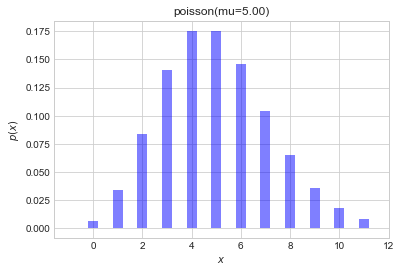

In [11]:
plot_rv(P_5)

# Coin Experiment

The purpose of the coin experiment is to illustrate the difference between **verifying** a hypothesis $h_m \in H = \{h_1, h_2, \cdots, h_M \}$ in a finite hypothesis set $H$, i.e.

$$\mathbb{P}\left[ \mid E_{in}(h_m) - E_{out}(h_m) \mid > \epsilon \right] \leq 2 e^{- 2 \epsilon^2 N}$$

and **learning** the best hypothesis $g \in H$. In the later case, $g$ depends on the dataset $D$ using during learning and the bound is looser, i.e. it now also contains $M$

$$\mathbb{P}\left[ \mid E_{in}(g) - E_{out}(g) \mid > \epsilon \right] \leq 2 M e^{- 2 \epsilon^2 N}$$

In the experiment we run a computer simulation where we flip 1,000 fair coins. Each coin is flipped 
independently 10 times. The experiment is repeated 1,000,000 times. Let's  focus on 3 coins as  follows: 

   1. $c_1$ is the first coin flipped,
   2. $c_{rand}$ is a coin you choose at random 
   3. $c_{min}$ is the coin that had the minimum frequency of heads (pick the earlier one in case of a tie). 
  
Let $\nu_1$, $\nu_{rand}$ and $\nu_{min}$ be the fraction of heads obtained for the above three coins.
The first two coins play the role of fixed hypotheses, i.e. the first and a random one, while the last coin plays the role of the final hypothesis $g$.

In [12]:
def get_coin(heads, idx_coin=0):
    '''Input: the number of heads for each coin in each experiment.
       Output: the number of heads of the coin with given index.'''
    return heads[idx_coin, :]

def get_max(heads):
    '''Input: the number of heads for each coin per experiment.
       Output: the maximum number of heads per experiment.'''
    return np.max(heads, axis=0)

def get_min(heads):
    '''Input: the number of heads for each coin per experiment.
       Output: minimum number of heads per experiment.'''
    return np.min(heads, axis=0)

def get_random(heads):
    '''Input: the number of heads for each coin per experiment.
       Output: the number of heads of a random coin per experiment.'''
    nb_coins, nb_exps = heads.shape
    rnd_indices = np.random.randint(low=0, high=nb_coins, size=nb_exps)
    #return heads.T[np.arange(nb_exps), rnd_indices]
    return heads[rnd_indices, np.arange(nb_exps)]

In [13]:
def run_experiments(success_rate, nb_trials, nb_coins, nb_exps):
    # Generate the trials for each coin and repeat this for each experiment
    flips = np.random.binomial(n=1, p=success_rate, size=(nb_trials, nb_coins, nb_exps))
    # Count the number of heads for each coin and repeat this for each experiment
    heads = np.sum(flips, axis=0)
    coin_1, coin_rnd, coin_min = get_coin(heads, idx_coin=0), get_random(heads), get_min(heads)
    return success_rate, flips, heads, coin_1, coin_rnd, coin_min

# Run and visualize an experiment

## Inspect

In [14]:
def get_experiment_flips(flips, idx_exp):
    '''Input: the flips of each coin in each experiment.
       Output: the flips of each coin in the experiment with given index.'''
    return flips[:, :, idx_exp]

def get_coin_flips(flips, idx_coin, idx_exp=0):
    '''Input: the flips of each coin in each experiment.
       Output: the flips of the coin in the experiment with given indices.'''
    nb_trials, nb_coins, nb_exps = flips.shape
    assert idx_coin < nb_coins and idx_exp < nb_exps
    exp_flips = get_experiment_flips(flips, idx_exp)
    coin_flips = exp_flips[:, idx_coin]
    return coin_flips

## Visualize

In [15]:
def plot_histogram(mu, flips, heads, heads_1, heads_rnd, heads_min):
    # Get the data
    nb_trials, nb_coins, nb_exps = flips.shape
    max_value = nb_trials+1
    data = [heads_1, heads_rnd, heads_min]
    
    # Plot the 3 histograms
    fig, ax = plt.figure(), plt.axes()
    colors, labels  = ['yellow', 'red', 'blue'], [r'$H_1$', r'$H_{rnd}$', r'$H_{min}$']
    edges = np.linspace(start=-0.5, stop=max_value+0.5, endpoint=True, num=max_value+2)
    kwargs = dict(bins=edges, normed=1, histtype='stepfilled', alpha=0.5)
    ax.hist(data, label=labels, color=colors, **kwargs)
    
    # Plot the binomial
    x = np.arange(max_value)
    binom = ss.binom(n=nb_trials, p=mu)
    ax.plot(x, binom.pmf(x), 'ko--', label='Binom')
    
    # Give the information of the plot.
    title = 'Estimate of number of heads\n' + \
             r'for $N$ = {0:d} trials when the success rate $\mu$ = {1:1.1f}'.format(nb_trials, mu)
    ax.set(xlabel=r'Number of heads $n$', xticks=get_ticks(rv=binom),
           ylabel=r'Relative Frequency', title=title)
    ax.legend(loc='best')

## Take notice
It takes some time to run the experiment as described above. Therefor, we use 1,000 coins and repeat the experiment 10,000 times instead.

In [16]:
MU, FLIPS, HEADS, HEADS_1, HEADS_rnd, HEADS_min =\
    run_experiments(success_rate=0.5, nb_trials=10, nb_coins=100, nb_exps=10000)

### Inspect the outcome of the first $N$ experiments

In [17]:
#FIRST_N = 5
#FLIPS.shape, HEADS.shape, HEADS_1[:FIRST_N], HEADS_rnd[:FIRST_N], HEADS_min[:FIRST_N]

In [18]:
#get_coin_flips(flips=FLIPS, idx_coin=0, idx_exp=0)

### Visualize the outcome of *all* experiments

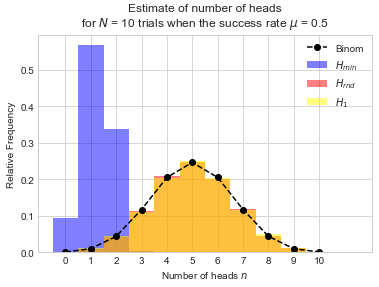

In [19]:
plot_histogram(mu=MU, flips=FLIPS, heads=HEADS, 
               heads_1=HEADS_1, heads_rnd= HEADS_rnd, heads_min=HEADS_min)

## Conclusion

From the figure above where $N = 10$ and if we take for instance $\epsilon = 0.3$ we can conclude that the Hoeffding bound holds for both the coins $c_1$ and $c_{rnd}$ but not for $c_{min}$. 

For the specified values, the Hoeffding bound is $\pm 33 \%$ while the probability for the event $\mathbb{P}\left[ (\mid \mu - \nu \mid ) > \epsilon \right]$ is approximated by area of the bars $0, 1, 9, \text{ and } 10$. For $c_1$ and $c_{rnd}$ these areas are clearly less than 1/3 of the total area while for $c_{min}$ that area is more than 90% and exceeds the Hoeffding bound.

More details are given in the sections below.

# Bernoulli and binomial distributions

Throwing up a coin with success rate $\mu$ is represented by a *Bernoulli* random variable 
$X \sim Ber(\mu), ~n= 1, \cdots, N$. Its distribution is given by $\mathbb{P}(X = 1) = \mu$ and $\mathbb{P}(X = 0) = 1 - \mu$. We interpret the outcomes *Head* as 1 and *Tail* as 0. The mean $\mathbb{E}(X)$ and variance $\mathbb{V}(X)$ of this distribution are $\mu$ and $\mu (1 - \mu)$, respectively.

If we have $N$ independent trials of this experiment then the sequence of $N$ outcomes has a *binomial* distribution $B(N, \mu)$ where the parameter $N$ is the number of trials and $\mu$ the success rate of the coin. Its mean and variance are $N \mu$ and $N \mu (1 - \mu)$, respectively. The *sample mean* of a sequence of $N$ trials will be represented by $\nu = \frac{\#1}{N}$ where $\#1$ is the number of $1$s in the sequence. 

The probability that we find $n$ successes in the $N$ trials is given by
$$\mathbb{P}(X = n) = \binom{N}{n} \mu^n (1 - \mu)^{N - n}$$
where 
$$\binom{N}{n} \triangleq \frac{N!}{(N-n)! n!}$$

## Plot the binomial distribution for $N$ trials and success rate $\mu$

We plot the probability mass function or $pmf$ and the cumulative distribution function or *cdf* of the *binomial* distribution for the success rates $\mu = 0.1, 0.2, 0.3, 0.4 , 0.5$ and the given number of trails $N$.

Plot either the *probability mass function* or the *cumulative distribution function* of the binomial distribution for given success rate $\mu$ when the number of trials $N$ is given.

In [20]:
def plot_binomials(nb_trials, cdf=False, success_rates=[0.1, 0.2, 0.3, 0.4, 0.5]):
    fig, ax = plt.figure(), plt.axes()
    colors = ['r', 'g', 'b', 'y', 'k'] 
    
    x = np.arange(nb_trials+1)
    for success_rate, color in zip(success_rates, colors):
        binom = ss.binom(n=nb_trials, p=success_rate)
        f = binom.cdf if cdf else binom.pmf
        marker = '{0:s}o--'.format(color)
        ax.plot(x, f(x), marker, label=r'$\mu$ = {0:0.1f}'.format(success_rate))

    ax.set(xlabel=r'$N \nu$', xticks=get_ticks(rv=binom),
           ylabel=r'Probability $p(N \nu|\mu, N)$', 
           title=r'Binomial distribution for $N$ = {0:d} trials'.format(nb_trials))
    ax.legend(loc='best')

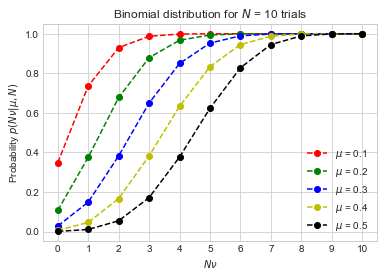

In [21]:
plot_binomials(nb_trials=10, cdf=True)

## Evaluating $\mathbb{P}\left[ (\mid \mu - \nu \mid ) > \epsilon \right]$ when $\nu$ has a binomial distribution

   1. For a given $\mu$ and $\epsilon$ we evaluate  $\mid \mu - \nu \mid > \epsilon$ for all $\nu$. 
   Note that we compare $\nu$ and $\mu$ multiplied by $N$ instead and that $n = N \nu$ is the number of heads in 
   the sample. This is always an integer between $0$ and $N$.
   2. Next we select the number of heads $n$ for which $\mid N \mu - n \mid > N \epsilon$ is True
   3. Finally we sum the probabilities of these $n$

In [22]:
def make_event_p(mu, eps, N):
    @vectorize([boolean(int64)])
    def event_p(heads):
        return np.abs(N*mu - heads) > N*eps
    return event_p

In [23]:
def prob(pmf, event):
    return np.sum(pmf(event))

### Example evaluation

First,

   1. Specify the success rate $\mu$, tolerance $\epsilon$ and number of trials $N$
   2. Generate the domain of the binomial distribution: $\{0, 1, \cdots, N \}$
   3. Return the event with the specified parameters

In [24]:
mu, eps, N = 0.5, 0.1, 10
domain = np.arange(N+1)
event_p = make_event_p(mu, eps, N)

Next,  
   4. Determine for element in the sample space whether it belongs to the specified event 
   5. Select the elements belonging to the event
   6. Sum their probabilities using the probability mass function of the binomial distribution
   7. This gives the probability of that event

In [25]:
selected = event_p(domain)
bad_event = domain[selected]
pmf = ss.binom(n=N, p=mu).pmf
prob(pmf, bad_event)

0.3437500000

# Inequalities

## Chebyshev Inequality

The **Chebyshev inequality** applies to any random variable with finite variance $\sigma^2$ but it provides a much looser bound than Hoeffding when the latter one is applicable.

Let $X_1, X_2, \cdots, X_N$ be independent and identically distributed random variables with finite variance $\sigma$ and let $\overline{X} = \frac{1}{N}\sum_{n=1}^N X_n$ be their *sample mean*. Then

$$\mathbb{P}\left[ \mid \overline{X} - \mathbb{E}(\overline{X}) \mid > \epsilon \right] \leq \frac{\sigma^2}{N \epsilon^2}$$

Note that finite variance implies finite mean.

## Hoeffding Inequality

The **Hoeffding inequality** states that when these $X_n$ are **bounded** by the interval
$\left[0, 1 \right]$ then

$$\mathbb{P}\left[ \mid \overline{X} - \mathbb{E}(\overline{X})  \mid > \epsilon \right] \leq 2 e^{- 2 \epsilon^2 N}$$

When the $X_n$ are **bounded** by the interval $\left[a, b \right]$ then the inequality becomes 

$$\mathbb{P}\left[ \mid \overline{X} - \mathbb{E}(\overline{X})  \mid > \epsilon \right] \leq 2 e^{- \frac{2 \epsilon^2 N}{(b-a)^2}}$$

For example, $a = 0$ and $b = K$ for $Binom(K,\mu)$. 

## Relation between $\delta, \epsilon \text{ and } N$

If we set $\delta$ equal to the upper bound we get
$$\mathbb{P}\left[\mid \overline{X} - \mathbb{E}(\overline{X})  \mid > \epsilon \right] \leq \delta \text{      and      } 
\mathbb{P}\left[\mid \overline{X} - \mathbb{E}(\overline{X})  \mid \leq \epsilon \right] \leq 1 - \delta$$ 
for the *bad* and *good* event, respectively.

In case of Chebyshev $$\delta_C = \frac{\sigma^2}{N \epsilon^2}$$ 

For i.i.d. Bernoulli random variables with success rate $\mu$ this becomes 

$$\delta_C = \frac{\mu (1 - \mu)}{N \epsilon^2}$$ 

since their variance is $\mu (1 - \mu)$.

And, in case of the Hoeffding

$$\delta_H = 2 e^{-2 N \epsilon^2}$$




From these bounds we can derive expressions for $N$ as a function of $\delta$ and $\epsilon$ 
and $\epsilon$ as a function of $\delta$ and $N$. For instance, in case of Hoeffding we get 

$$N_H = \frac{1}{2 \epsilon^2}\ln \frac{2}{\delta}$$ 

and 

$$\epsilon_H = \sqrt{\frac{1}{2N} \ln \frac{2}{\delta}}$$

In [26]:
def get_delta(eps, N):
    """Returns the probability delta as a function of the tolerance epsilon 
       and the number trials N"""
    return 2*np.exp(-2*N*eps**2)

def get_N(delta, eps):
    """Returns the number of trials N as a function of the probability delta 
       and the tolerance epsilon."""
    N = np.log(2/delta)/(2*eps**2)
    return ceil(N)

def get_eps(delta, N):
    """Returns the tolerance epsilon as a function of the probability delta 
       and the number of trials N."""
    eps = np.sqrt(np.log(2/delta)/(2*N))
    return eps

## Calculate the Chebyshev bound

For a specified success rate $\mu$, plot the Chebyshev bound $\delta_C (N, \epsilon) = \frac{\mu (1 - \mu)}{N \epsilon^2}$ for several values of the tolerance $\epsilon$ and the sample size $N$

   * For given values of $\epsilon$ we return the Chebyshev bound as a function of $N$, and
   * For given values of $N$ we return the Chebyshev bound as a function of $\epsilon$

In [27]:
 def make_Chebyshev_of_N(mu, eps):
    @vectorize([float64(float64)])
    def Chebyshev(N):
        c = mu*(1-mu)/eps**2
        return c/N
    return Chebyshev

 def make_Chebyshev_of_eps(mu, N):
    @vectorize([float64(float64)])
    def Chebyshev(eps):
        c = mu*(1-mu)/N
        return c/eps**2
    return Chebyshev

## Calculate the Hoeffding bound

Plot the Hoeffding bound $\delta_H (N, \epsilon) = 2 e^{- 2 \epsilon^2 N}$ for several values of the tolerance $\epsilon$ and the sample size $N$.

   * For given values of $\epsilon$ we return the Hoeffding bound as a function of $N$, and
   * For given values of $N$ we return the Hoeffding bound as a function of $\epsilon$

In [28]:
def make_Hoeffding_of_N(eps):
    @vectorize([float64(float64)])
    def Hoeffding(N):
        return 2*np.exp(-2*N*eps**2)
    return Hoeffding

def make_Hoeffding_of_eps(N):
    @vectorize([float64(float64)])
    def Hoeffding(eps):
        return 2*np.exp(-2*N*eps**2)
    return Hoeffding

## Plot the bounds

Note that in the plots we use logarithmic scale for the $x$- and/or $y$-axis.

In [29]:
from matplotlib import colors as mcolors
COLORS = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

In [30]:
def plot_bounds(mu=0.5,
                max_N=10**5, 
                eps_vals=[0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001]):
    global COLORS
    fig, (top, bottom)  = plt.subplots(2)
    
    # Plot the bound as a function of N for a range of values of epsilon 
    # using ogarithmic scale.
    max_logN = ceil(np.log10(max_N))
    N_range = np.logspace(0, max_logN)
    
    for eps, color in zip(eps_vals, COLORS):
        eps_pct = 100*eps
        Hoeffding_N, Chebyshev_N = make_Hoeffding_of_N(eps), make_Chebyshev_of_N(mu, eps)
        top.plot(N_range, Chebyshev_N(N_range), 
                 color=color, linestyle='--') 
        top.plot(N_range, Hoeffding_N(N_range), 
                 color=color, label=r'$\epsilon$ = {0:2.2f} %'.format(eps_pct))

    top.set(xscale='log', xlabel=r'Sample size $N$', 
            yscale='log', ylim=(0.1**5, 0.50), ylabel=r'Bound $\delta$',
            title=r'Hoeffding and Chebyshev (dashed) bound as a function of $N$')
    top.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Plot the bound as a function of epsilon for a range of values of N
    eps_range = np.linspace(10**-5, 0.5, 100, endpoint=True)
    
    exps = np.arange(1, max_logN+1)
    for exp, color in zip(exps, COLORS):
        N = 10**exp
        Hoeffding_eps = make_Hoeffding_of_eps(N=N)
        Chebyshev_eps = make_Chebyshev_of_eps(mu=mu, N=N)
        bottom.plot(eps_range, Chebyshev_eps(eps_range),
                    color=color, linestyle='--')
        bottom.plot(eps_range, Hoeffding_eps(eps_range), 
                    color=color, label=r'$N$ = {0:1.1e}'.format(N))

    bottom.set(xlabel=r'Tolerance $\epsilon$', 
               yscale='log', ylim=(10**-5, 0.2), ylabel=r'Bound $\delta$',
               title=r'Hoeffding and Chebyshev (dashed) bound as a function of $\epsilon$')
    bottom.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # To avoid that the text of the subplots overlap.
    fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)

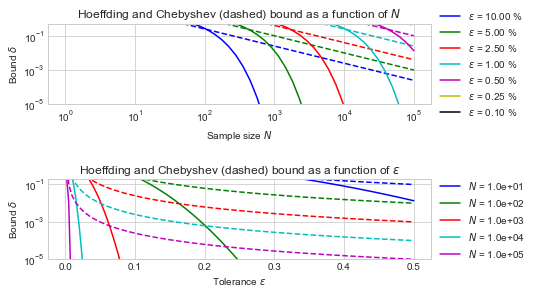

In [31]:
plot_bounds(max_N=10**5)

## Conclusion

The figures above show that the Chebyshev bound is indeed a looser bound than the Hoeffding bound for sufficiently large $N$, cfr. the top figure.

# Testing the Hoeffding bound

We test the bound on 

   * Distributions with *bounded range* for which the Hoeffding inequality holds. Without loss of generality we can assume that the range is the closed interval $[0, 1]$, 
   * Other distributions like the *Gaussian* and *Poisson* distribution that don't meet the 
     conditions and so the Hoeffding inequality does not necessarily holds.

The **test** is done as follows

   * We generate N samples of a given distribution and calculate the sample mean $\overline{X} = \sum_{n=1}^N X_n$ and compare it with the true mean $\mu$
   * We record the outcome of $\mid \overline{X} - \mu \mid > \epsilon$. Note that this is a Bernoulli random variable $Y$ with unknown mean $\mu_Y$ and unknown variance $\sigma_Y^2 = \mu_Y (1 - \mu_Y)$
   * We repeat this experiment $K$ times and collect the outcomes
   * The relative frequency that the outcome of an experiment is *True* 
   is an estimate $\hat{\mu}_Y$ of the true probability 
   $$\mathbb{P}\left( \mid \overline{X}_N - \mu \mid > \epsilon \right)$$
   * The standard error $se_Y$ of this estimate is given by 
   $$se_Y = \frac{\hat{\sigma}_Y}{\sqrt{M}}$$
   * We plot the estimate with its error bars and compare it to the Hoeffding bound.

In [32]:
def estimate_bad(distr, eps, N, nb_exps):
    '''Input: probability distribution, the tolerance eps, the number of trials N, 
       and the number of times we repeat this experiment.
       Output: estimate of the probability with standard error based on the number of 
       experiments.'''
    mean = distr.mean()
    delta = get_delta(eps, N)
    
    samples = distr.rvs(size=(N, nb_exps))
    avgs = np.average(samples, axis=0)
    outcomes = np.abs(avgs - mean) > eps
    avg_outcome = np.average(outcomes)
    se = np.sqrt(avg_outcome*(1-avg_outcome)/nb_exps)
    return avg_outcome, se, delta

In [33]:
def calculate_estimates(distr, eps, nb_exps, N_range):
    size_domain = len(N_range)
    estimates = np.zeros(size_domain, dtype=np.float64)
    standard_errors = np.zeros(size_domain, dtype=np.float64)
    deltas = np.zeros(size_domain, dtype=np.float64)
    
    for n, N in enumerate(N_range):
        estimates[n], standard_errors[n], deltas[n] = estimate_bad(distr, eps, N, nb_exps)
    
    return estimates, standard_errors, deltas

## Visualization of the bound

The default is to use logarithmic scale for both the $x$- and $y$-axis.



In [34]:
def plot_estimates(eps, nb_exps, N_range, logscale=True, bounded_range_p=True, conf_factor=3):
    global RVs
    fig, ax = plt.figure(), plt.axes()
    
    if bounded_range_p:
        rvs = [rv for rv in RVs if bounded_p(rv)]
    else:
        rvs = [rv for rv in RVs if not bounded_p(rv)]
        
    for rv, color in zip(rvs, COLORS):
        # Plot the estimates for each distribution
        estimates, standard_errors, deltas = calculate_estimates(rv, eps, nb_exps, N_range)
        ax.plot(N_range, estimates, color=color, label=rv.dist.name)
        
        # Plot the errorbars
        confidences =  conf_factor*standard_errors
        ax.fill_between(N_range, estimates - confidences, estimates + confidences, 
                        color='grey', alpha=0.2)
    
    # Plot the Hoeffding bound 
    ax.plot(N_range, deltas, 'k--', label=r'Hoeffding bound $\delta$')
    
    # 
    if logscale:
        ax.set_xscale('log', basex=2)
        ax.set_yscale('log', basey=2)
        ax.set_ylim(2**-10, 2**0)
        
    s = 'Bounded' if bounded_range_p else 'Unbounded'
    ax.set(xlabel=r'$N$', 
           ylabel=r'$\mathbb{P}\left[ (\mid \mu - \nu \mid ) > \epsilon \right]$',
           title=r'Hoeffding Test for Distributions with {0:s} Support'.format(s))
        
    ax.legend(loc='best')

In [35]:
def generate_N_range(exponential=False, num=10, max_logN=20):
    assert type(max_logN) is int, 'Argument max_logN has to be in integer between 0 and 20.'
    if exponential:
        return np.array(2**(np.arange(max_logN+1)),dtype = np.int64)
    else:
        return np.linspace(start=1, stop=2**max_logN + 1, num=num, dtype=np.int64)

## Visualize Hoeffding test for distributions with and without bounded range

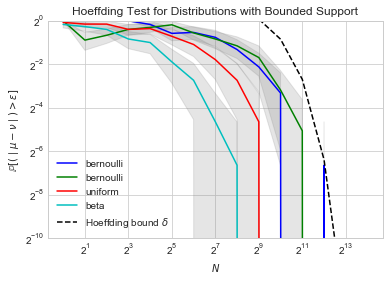

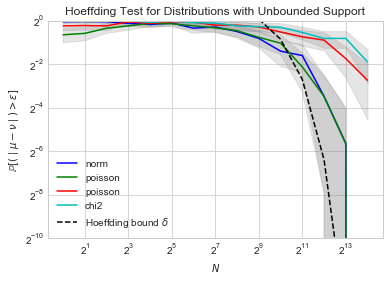

In [36]:
for boolean in True, False:
    plot_estimates(eps=0.025, 
                   nb_exps=100,
                   N_range=generate_N_range(exponential=True, max_logN=14), 
                   bounded_range_p=boolean)

## Conclusion

The above two figures show that the Hoeffding bound always holds for distributions with bounded range, cf. the top figure. In contrast, the bottom figure shows that this bound not always hold when a distribution has unbounded range.

Note that we have restricted ourselves to the range $[0, 1]$ but the Hoeffding bound can be generalized to any bounded range $[a, b]$, cf. the section on the Hoeffding inequality above.

# Overall conclusion

To Be Added, repeat the structure of the Introduction.